# Ensemble Approach

Approach to build Ensemble Models with Hard- and Softvoting.
The goal is to further improve the model performance

In [1]:
%%capture
!pip install transformers
!pip install datasets
!pip install torchvision
!pip install wandb
!pip install ipynb
!pip install s3fs
!pip install nvidia-ml-py3
!pip install sentencepiece

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import EarlyStoppingCallback
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report 
from transformers import get_scheduler
from transformers import AdamW
import shutil
import pandas as pd
import json
import s3fs
import os
import torch
from ipynb.fs.full.eval_metrics import *
hello()

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

torch.cuda.is_available()

# Opening JSON file
with open('../credentials.json', 'r') as openfile:
 
    # Reading from json file
    json_object = json.load(openfile)
    key = json_object["key"]
    secret = json_object["secret_key"]
    bucket_name = json_object["bucket_name"]

s3 = s3fs.S3FileSystem(anon=False,key=key,secret=secret)

Hello World!


In [3]:
ansatz = "Ensemble"

train_test_number = [5]

train_file_name = "train_plus_neutral_germeval.csv"
test_file_name = "test_plus_neutral_germeval.csv"

In [4]:
# Load Test Datsets from foler KFOLD1 to KFOLD5
with s3.open(f"{bucket_name}/KFOLD5/{train_file_name}",'r') as file:
    data = pd.read_csv(file)
with s3.open(f"{bucket_name}/KFOLD5/{test_file_name}",'r') as file:
    test_data = pd.read_csv(file)
data = data[["Text", "majority_vote"]]
test_data = test_data[["Text", "majority_vote"]]
data.rename(columns={'Text': 'text', 'majority_vote': 'labels'}, inplace=True)
test_data.rename(columns={'Text': 'text', 'majority_vote': 'labels'}, inplace=True)

In [35]:
# Initialize different tokenizers  to check which ensembles perform best

tokenizer = AutoTokenizer.from_pretrained("EIStakovskii/german_toxicity_classifier_plus_v2")
tokenizer1 = AutoTokenizer.from_pretrained("german-nlp-group/electra-base-german-uncased")
tokenizer2 = AutoTokenizer.from_pretrained("deepset/gbert-base")
#tokenizer3 = AutoTokenizer.from_pretrained("T-Systems-onsite/cross-en-de-roberta-sentence-transformer")
#tokenizer4 = AutoTokenizer.from_pretrained("bert-base-german-dbmdz-uncased")
#tokenizer5 = AutoTokenizer.from_pretrained("shahrukhx01/gbert-hasoc-german-2019")
#tokenizer6 = AutoTokenizer.from_pretrained("xlm-roberta-base")

loading file vocab.txt from cache at /home/jovyan/.cache/huggingface/hub/models--EIStakovskii--german_toxicity_classifier_plus_v2/snapshots/6c8e91acf96ceeb7f92386057251e3e988d759e6/vocab.txt
loading file tokenizer.json from cache at /home/jovyan/.cache/huggingface/hub/models--EIStakovskii--german_toxicity_classifier_plus_v2/snapshots/6c8e91acf96ceeb7f92386057251e3e988d759e6/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /home/jovyan/.cache/huggingface/hub/models--EIStakovskii--german_toxicity_classifier_plus_v2/snapshots/6c8e91acf96ceeb7f92386057251e3e988d759e6/special_tokens_map.json
loading file tokenizer_config.json from cache at /home/jovyan/.cache/huggingface/hub/models--EIStakovskii--german_toxicity_classifier_plus_v2/snapshots/6c8e91acf96ceeb7f92386057251e3e988d759e6/tokenizer_config.json
loading configuration file config.json from cache at /home/jovyan/.cache/huggingface/hub/models--german-nlp-group--electra-b

In [36]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [37]:
# ----- 3. Predict -----#
# Load test data and tokenize it with the specific toeknizer
X_test = list(test_data["text"])
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)
X_test_tokenized1 = tokenizer1(X_test, padding=True, truncation=True, max_length=512)
X_test_tokenized2 = tokenizer2(X_test, padding=True, truncation=True, max_length=512)
#X_test_tokenized3 = tokenizer3(X_test, padding=True, truncation=True, max_length=512)
#X_test_tokenized4 = tokenizer4(X_test, padding=True, truncation=True, max_length=512)
#X_test_tokenized5 = tokenizer5(X_test, padding=True, truncation=True, max_length=512)
#X_test_tokenized6 = tokenizer6(X_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
test_dataset = Dataset(X_test_tokenized)
test_dataset1 = Dataset(X_test_tokenized1)
test_dataset2 = Dataset(X_test_tokenized2)
#test_dataset3 = Dataset(X_test_tokenized3)
#test_dataset4 = Dataset(X_test_tokenized4)
#test_dataset5 = Dataset(X_test_tokenized5)
#test_dataset6 = Dataset(X_test_tokenized6)

# Load trained models
#model = AutoModelForSequenceClassification.from_pretrained(f"BEST_Model_Toxicity_Ensemble_best_model", num_labels=2)
# mit dem Toxicity F1 Macro von 0.9 aber duplikate checken. Dennoch für Germeval möglich
model = AutoModelForSequenceClassification.from_pretrained(f"BEST_Model_Toxicity_Ensemble_best_model", num_labels=2)
model1 = AutoModelForSequenceClassification.from_pretrained(f"BEST_Model_Electra_with_Germeval_training_run5_best_model", num_labels=2)
#model1 = AutoModelForSequenceClassification.from_pretrained(f"BEST_Model_Electra_best_model", num_labels=2)
model2 = AutoModelForSequenceClassification.from_pretrained(f"BEST_Model_gbert_base_Ensemble_best_model", num_labels=2)
#model3 = AutoModelForSequenceClassification.from_pretrained(f"BEST_Model_roberta_t_systems_Ensemble_best_model", num_labels=2)
#model4 = AutoModelForSequenceClassification.from_pretrained(f"BEST_Model_bert_dbmdz_Ensemble_best_model", num_labels=2)
#model5 = AutoModelForSequenceClassification.from_pretrained(f"shahrukhx01/gbert-hasoc-german-2019", num_labels=2)
#model6 = AutoModelForSequenceClassification.from_pretrained(f"xlm-roberta-base", num_labels=2)

# Define test trainer
test_trainer = Trainer(model)
test_trainer1 = Trainer(model1)
test_trainer2 = Trainer(model2)
#test_trainer3 = Trainer(model3)
#test_trainer4 = Trainer(model4)
#test_trainer5 = Trainer(model5)
#test_trainer6 = Trainer(model6)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)
raw_pred1, _1, _1 = test_trainer1.predict(test_dataset1)
raw_pred2, _2, _2 = test_trainer2.predict(test_dataset2)
#raw_pred3, _3, _3 = test_trainer3.predict(test_dataset3)
#raw_pred4, _4, _4 = test_trainer4.predict(test_dataset4)
#raw_pred5, _5, _5 = test_trainer5.predict(test_dataset5)
#raw_pred6, _6, _6 = test_trainer6.predict(test_dataset6)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)
y_pred1 = np.argmax(raw_pred1, axis=1)
y_pred2 = np.argmax(raw_pred2, axis=1)
#y_pred3 = np.argmax(raw_pred3, axis=1)
#y_pred4 = np.argmax(raw_pred4, axis=1)
#y_pred5 = np.argmax(raw_pred5, axis=1)
#y_pred6 = np.argmax(raw_pred6, axis=1)

loading configuration file BEST_Model_Toxicity_Ensemble_best_model/config.json
Model config BertConfig {
  "_name_or_path": "BEST_Model_Toxicity_Ensemble_best_model",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "neutral",
    "1": "toxic"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "neutral": 0,
    "toxic": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31102
}

loading weights file BEST_Model_Toxicity_Ensemb

***** Running Prediction *****
  Num examples = 319
  Batch size = 8


***** Running Prediction *****
  Num examples = 319
  Batch size = 8


In [38]:
# Build Numpy Arrays to be able to do Soft Voting
sum_array = np.add(raw_pred, raw_pred1)
sum_array = np.add(sum_array, raw_pred2)
# Bei 5 Classifiern
#sum_array = np.add(sum_array, raw_pred3)
#sum_array = np.add(sum_array, raw_pred4)
# bei 7 Classifiern
#sum_array = np.add(sum_array, raw_pred5)
#sum_array = np.add(sum_array, raw_pred6)

In [39]:
# Divide 1 by the number of classifiers
multi = np.multiply(sum_array, 0.33)
#multi = np.multiply(sum_array, 0.5)
multi[:5]

array([[-3.0195549,  3.1257925],
       [-3.0411592,  3.149917 ],
       [-3.0277221,  3.0879445],
       [-2.9622777,  3.049275 ],
       [-3.0159812,  3.1268773]], dtype=float32)

In [40]:
# Soft Voting
y_pred_soft = np.argmax(multi, axis=1)
y_pred_soft

array([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [41]:
# Hard Voting
y_pred_ens = []

for i in range(len(y_pred)):
    if y_pred[i] + y_pred1[i] + y_pred2[i]  > 1 :
        res = 1
        y_pred_ens.append(res)
    else:
        res = 0
        y_pred_ens.append(res)
        
y_pred_ens = np.array(y_pred_ens)
y_pred_ens

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

                             1
0                             
acc                   0.893417
bal_acc               0.893455
mcc                   0.787096
f1_macro              0.893408
f1_micro              0.893417
f1_weighted           0.893404
precision_macro       0.893641
precision_micro       0.893417
precision_weighted    0.893673
recall_macro          0.893455
recall_micro          0.893417
recall_weighted       0.893417
precision_class_0     0.903846
precision_class_1     0.883436
recall_class_0        0.881250
recall_class_1        0.905660
f1_score_class_0      0.892405
f1_score_class_1      0.894410
sample_class_0      160.000000
sample_class_1      159.000000
Finished Fold Number: Germeval


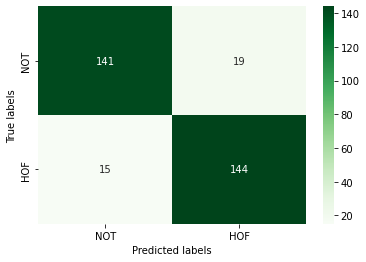

In [46]:
# Compare Hard Voting VS Soft Voting
#y_pred = y_pred_ens
y_pred = y_pred_soft

from sklearn.metrics import f1_score

test_list = test_data["labels"].tolist()
test_list = np.array(test_list)

    # Compute Evaluation Metrics
f = f1_multiclass(test_list, y_pred)
p = p_multiclass(test_list, y_pred)
r = recall_multiclass(test_list, y_pred)
a = accuracy_score(test_list, y_pred)
ba = balanced_accuracy_score(test_list, y_pred)
prs = precision_recall_fscore_support(test_list, y_pred)
m = matthews_corrcoef(test_list,y_pred)

results = {}
results["acc"] = a
results["f1"] = f
results["precision"] = p
results["recall"] = r
results["bal_acc"] = ba
results["prfs"] = prs
results["mcc"] = m

prepare_results(results)
result_df = dict_to_df(results)
#result_df.to_csv(f"Ensemble_3_results_hard_voting.csv")
print(result_df)
class_rep = classification_report(test_list, y_pred,target_names=["HOF", "NOT"])
cm = confusion_matrix(test_list, y_pred,)
ax = plt.subplot()
cm_plot = sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Greens');
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(['NOT', 'HOF'])
ax.yaxis.set_ticklabels(['NOT', 'HOF']);
cm_plot.figure.savefig(f"./Ensemble_Results/Ensemble_Own_Data/CM_Ensemble_3_results_hard_voting.png")
print(f"Finished Fold Number: Germeval")

# Predict 1000 Random Tweets for the Sanity Check

In [47]:
tweets = pd.read_csv("../full_datasets/all_mentions_data_combined_without_retweets.csv")
# Sample 1000 random tweets
tweets = tweets.sample(1000)

/tmp/ipykernel_1094/2785248682.py:1: DtypeWarning: Columns (1,2,4,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  tweets = pd.read_csv("../full_datasets/all_mentions_data_combined_without_retweets.csv")


In [48]:
tweets = tweets.text.dropna()
len(tweets)

980

In [49]:
anno = tweets[:100]

In [50]:
anno_df = pd.DataFrame()
anno_df["text"] = anno
anno_df

,text
1726998,@MichaelZimlich @GtzFrmming Wäre auch für dies...
1193770,@cdljsjh2 @MarionaMarione @Karl_Lauterbach War...
686792,@Ralf_Stegner so sieht ein Speichellecker aus.
1020273,@Sumoplay @Erwin_Rueddel @Karl_Lauterbach @CDU...
1028221,@Storch_i @maxmordhorst @DB_Bahn @DB_Presse @V...
...,...
979834,"@n_roettgen Also ich Wagenknecht lad, habe ich..."
390814,@DaldoDill @ninastahr @der_alex12 @gruene_juge...
1158230,@MarwinZander @Karl_Lauterbach Mega joke.😂 un...
717696,@realTomBohn @_MartinHagen @LindaTeuteberg @jo...


In [51]:
# ----- 3. Predict -----#
# Load test data
X_test = list(anno)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)
X_test_tokenized1 = tokenizer1(X_test, padding=True, truncation=True, max_length=512)
X_test_tokenized2 = tokenizer2(X_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
test_dataset = Dataset(X_test_tokenized)
test_dataset1 = Dataset(X_test_tokenized1)
test_dataset2 = Dataset(X_test_tokenized2)

# Load trained models
model = AutoModelForSequenceClassification.from_pretrained(f"BEST_Model_Toxicity_Ensemble_best_model", num_labels=2)
model1 = AutoModelForSequenceClassification.from_pretrained(f"BEST_Model_Electra_with_Germeval_training_run5_best_model", num_labels=2)
model2 = AutoModelForSequenceClassification.from_pretrained(f"BEST_Model_gbert_base_Ensemble_best_model", num_labels=2)

# Define test trainer
test_trainer = Trainer(model)
test_trainer1 = Trainer(model1)
test_trainer2 = Trainer(model2)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)
raw_pred1, _1, _1 = test_trainer1.predict(test_dataset1)
raw_pred2, _2, _2 = test_trainer2.predict(test_dataset2)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)
y_pred1 = np.argmax(raw_pred1, axis=1)
y_pred2 = np.argmax(raw_pred2, axis=1)

sum_array = np.add(raw_pred, raw_pred1)
sum_array = np.add(sum_array, raw_pred2)

multi = np.multiply(sum_array, 0.5)

y_pred_soft = np.argmax(multi, axis=1)
y_pred_soft

loading configuration file BEST_Model_Toxicity_Ensemble_best_model/config.json
Model config BertConfig {
  "_name_or_path": "BEST_Model_Toxicity_Ensemble_best_model",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "neutral",
    "1": "toxic"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "neutral": 0,
    "toxic": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31102
}

loading weights file BEST_Model_Toxicity_Ensemb

***** Running Prediction *****
  Num examples = 100
  Batch size = 8


***** Running Prediction *****
  Num examples = 100
  Batch size = 8


array([0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [52]:
preds = y_pred_soft.tolist()

In [53]:
# Append model predictions to the dataframe
anno_df["model_predictions"] = preds
anno_df.head(2)

,text,model_predictions
1726998,@MichaelZimlich @GtzFrmming Wäre auch für dies...,0
1193770,@cdljsjh2 @MarionaMarione @Karl_Lauterbach War...,0


In [54]:
anno_df.to_csv("sanity_check.csv", sep=";")

In [55]:
# Value counts of the classes
np.array(np.unique(y_pred1, return_counts=True)).T
## --> 16.33 % (15767 1 und 80808 0)sind Hate Tweets bei 100k Preds

array([[ 0, 78],
       [ 1, 22]])